# Download and process OpenRainER dataset

This notebook 
* downloads the dataset available on Zenodo https://doi.org/10.5281/zenodo.10593848
* crops to shorter periods 
* transforms into a common data structure
* shows some statisitcs and comparisons of the CML and reference data
* does some basic CML processing
* and saves to NetCDF

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import opensense_data_downloader_and_transformer as oddt
import pycomlink as pycml
import glob as glob
import pandas as pd
import poligrain as plg
import pyproj
import gzip, tarfile
import zipfile
import shutil
import os

## Download full dataset

In [3]:
# storing to external datasource as this is big due to the radar ref
oddt.download_data_file(
    url="https://zenodo.org/api/records/14731404/files-archive",
    local_path="data/OpenRainER/", 
    local_file_name='files-archive.zip', print_output=True
)

Creating path data/OpenRainER/
to data/OpenRainER//files-archive.zip


('data/OpenRainER/files-archive.zip', <http.client.HTTPMessage at 0x318366fd0>)

## Extract raw data files

This is based on the notebook and code by Eli Covi introduced here https://github.com/OpenSenseAction/radar_adjustment_intercomparison/pull/8

In [4]:
data_dir = 'data/OpenRainER/'

In [6]:
# unzip files
with zipfile.ZipFile(data_dir+'files-archive.zip') as zfile:
    zfile.extractall(data_dir)

In [7]:
#untar dowloaded files
for tar_filename in os.listdir(data_dir):
    if tar_filename.endswith('.tar'):
        tar_path = os.path.join(data_dir, tar_filename)
        
        # Estrazione del file .tar
        with tarfile.open(tar_path, 'r') as tar:
            tar.extractall(data_dir)  # Estrai tutto nella stessa directory

In [9]:
# unzip through all files in the directory
for filename in os.listdir(data_dir):
    # Check if the file has a .gz extension | select only 1 month
    if (filename.endswith('.gz')) & ('202208' in filename):
        gz_path = os.path.join(data_dir, filename)
        unzipped_path = os.path.join(data_dir, filename[:-3])  # Remove the .gz extension
        
        # Unzip the file
        with gzip.open(gz_path, 'rb') as f_in:
            with open(unzipped_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        
        # Delete the original .gz file 
        os.remove(gz_path)

In [182]:
fns = sorted(glob.glob(data_dir+"/AWS_20220[7-8]*nc"))

In [183]:
ids=[]
for fn in tqdm(fns):
    tmp = xr.open_dataset(fn)
    ids.append(set(tmp.id.values))
common_ids = list(set.intersection(*ids))

rainfall=[]
for fn in tqdm(fns):
    tmp = xr.open_dataset(fn)
    tmp = tmp.sel(id=common_ids)
    rainfall.append(tmp.rainfall_amount.load())


100%|██████████| 1/1 [00:00<00:00, 54.90it/s]


In [184]:
ds_rainfall = xr.concat(rainfall, dim='time')
ds_rainfall = ds_rainfall.rename({"longitude": "lon", "latitude": "lat"})

ds_rainfall.to_netcdf(data_dir+"AWS_rainfall.nc")

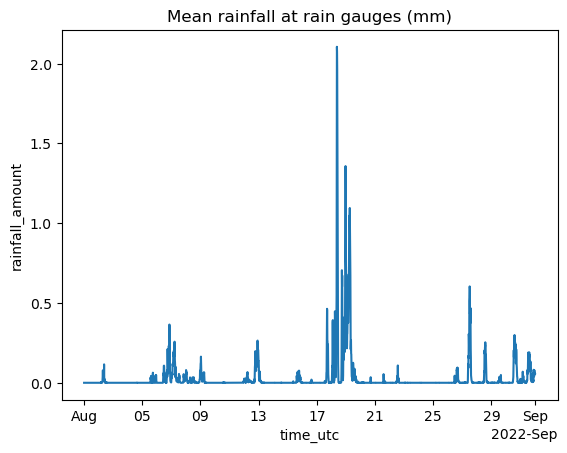

In [185]:
ds_rainfall.mean(dim='id').plot()
plt.title('Mean rainfall at rain gauges (mm)');

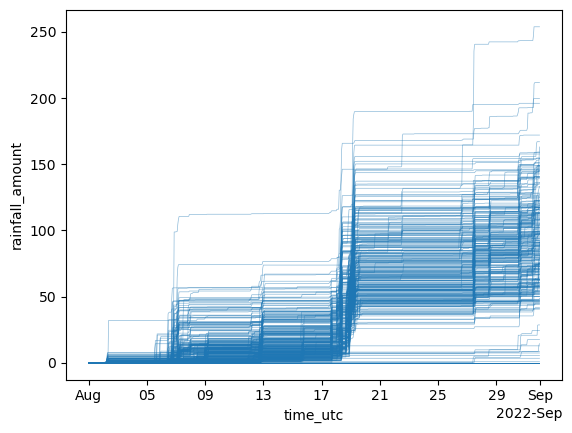

In [186]:
ds_rainfall.resample(time='1h').sum().cumsum(dim='time').plot.line(x='time', add_legend=False, color='C0', linewidth=0.5, alpha=0.5);

In [187]:
ds_rainfall.to_netcdf('OpenRainER_rain_gauges.nc')

#### Merge cmls to one dataset

In [188]:
fn

'data/OpenRainER/AWS_202208.nc'

In [189]:
fns = sorted(glob.glob(data_dir+"CML_202208*"))
ids=[]
for fn in tqdm(fns):
    tmp = xr.open_dataset(fn)
    ids.append(set(tmp.cml_id.values))
common_ids = list(set.intersection(*ids))

cmls=[]
for fn in tqdm(fns):
    tmp = xr.open_dataset(fn) 
    tmp = tmp.sel(cml_id=common_ids)
    cmls.append(tmp.load())


100%|██████████| 1/1 [00:00<00:00,  7.51it/s]


In [190]:
ds_cmls = xr.concat(cmls,dim='time')

In [191]:
#ds_cmls['frequency'] = ds_cmls['frequency'].isel(time=1).drop_vars('time')
#ds_cmls['polarization'] = ds_cmls['polarization'].isel(time=1).drop_vars('time')

In [192]:
ds_cmls.nbytes/1e9

0.215550648

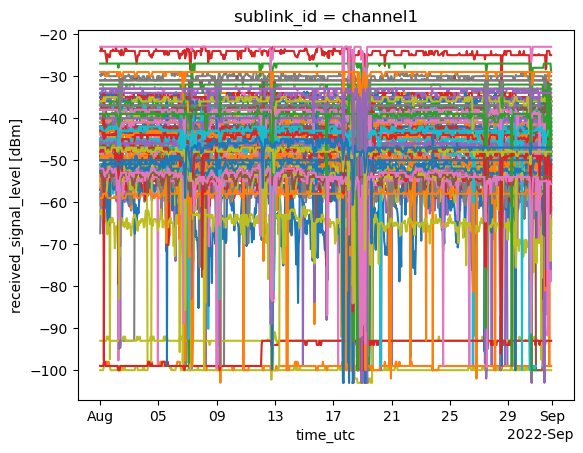

In [193]:
ds_cmls.isel(sublink_id=0).rsl.resample(time='1h').min().plot.line(x='time', add_legend=False);

## Crop to specific time period and rename datasets

In [194]:
t_start = '2022-08-14'
t_end = '2022-08-21'

ds_cmls = ds_cmls.sel(time=slice(t_start, t_end))
ds_gauges = ds_rainfall.sel(time=slice(t_start, t_end)).to_dataset()


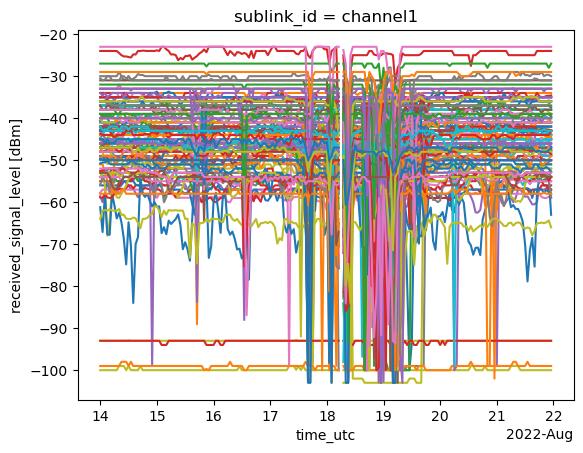

In [195]:
ds_cmls.rsl.isel(sublink_id=0).resample(time='1h').min().plot.line(x='time', add_legend=False);

## Load radar data

In [196]:
fns_radar = sorted(glob.glob(data_dir+"/RADadj_202208*"))

list_radar=[]
count=[]
for i in tqdm(range(len(fns_radar))):
    ds_radar = xr.open_dataset(fns_radar[i])
    # remove unnecessary cords and variables
    ds_radar = ds_radar.drop_vars(['geo_dim','mesh_dim','mosaic'])
    #add lon lat grid
    lon_grid, lat_grid = np.meshgrid(ds_radar.lon.values, ds_radar.lat.values)
    count.append(len(ds_radar.time))
    ds_radar.coords["lon_grid"] = (("lat", "lon"), lon_grid)
    ds_radar.coords["lat_grid"] = (("lat", "lon"), lat_grid)

    list_radar.append(ds_radar)

ds_radar_adjusted = xr.concat(list_radar, dim='time')

# fill in missing time steps
#ds_radar = ds_radar.reindex({'time':pd.date_range(ds_radar.time.min().values,ds_radar.time.max().values,freq='15min')})

100%|██████████| 1/1 [00:00<00:00, 127.81it/s]


In [197]:
fns_radar = sorted(glob.glob(data_dir+"/RADrain_202208*"))

list_radar=[]
count=[]
for i in tqdm(range(len(fns_radar))):
    ds_radar = xr.open_dataset(fns_radar[i])
    # remove unnecessary cords and variables
    ds_radar = ds_radar.drop_vars(['geo_dim','mesh_dim','mosaic'])
    #add lon lat grid
    lon_grid, lat_grid = np.meshgrid(ds_radar.lon.values, ds_radar.lat.values)
    count.append(len(ds_radar.time))
    ds_radar.coords["lon_grid"] = (("lat", "lon"), lon_grid)
    ds_radar.coords["lat_grid"] = (("lat", "lon"), lat_grid)

    list_radar.append(ds_radar)

ds_radar = xr.concat(list_radar, dim='time')

# fill in missing time steps
#ds_radar = ds_radar.reindex({'time':pd.date_range(ds_radar.time.min().values,ds_radar.time.max().values,freq='15min')})

100%|██████████| 1/1 [00:00<00:00, 93.16it/s]


In [198]:
ds_radar['R_gauge_adjusted'] = ds_radar_adjusted.rainfall_amount
ds_radar['R'] = ds_radar.rainfall_amount

ds_radar = ds_radar.drop_vars(['lon', 'lat']).rename({'lon_grid': 'lon', 'lat_grid': 'lat'})
ds_radar = ds_radar.rename_dims({'lon': 'x', 'lat': 'y'})

ds_radar = ds_radar.sel(time=slice(ds_cmls.time.min(), ds_cmls.time.max()))
ds_radar

<xarray.Dataset> Size: 998MB
Dimensions:           (time: 768, y: 290, x: 373)
Coordinates:
  * time              (time) datetime64[ns] 6kB 2022-08-14 ... 2022-08-21T23:...
    lon               (y, x) float32 433kB 8.5 8.513 8.525 ... 13.18 13.19 13.21
    lat               (y, x) float32 433kB 43.4 43.4 43.4 ... 46.0 46.0 46.0
Dimensions without coordinates: y, x
Data variables:
    rainfall_amount   (time, y, x) float32 332MB nan nan nan nan ... 0.0 0.0 nan
    R_gauge_adjusted  (time, y, x) float32 332MB nan nan nan nan ... 0.0 0.0 nan
    R                 (time, y, x) float32 332MB nan nan nan nan ... 0.0 0.0 nan
Attributes:
    title:         OpenRainER-RP: radar 15-min accumulated precipitation
    file_authors:  Elia Covi (ARPAE-SIMC Bologna (IT)); Giacomo Roversi (Ca' ...
    institution:   Hydro-Meteorological and Climate Service of Emilia-Romagna...
    date:          2025-01-01
    source:        ARPAE-SIMC, Bologna (IT) - Radar rain depth maps
    license:       https://creativecommons.org/licenses/by/4.0/
    contact:       elia.c.covi@gmail.com
    reference:     https://zenodo.org/doi/10.5281/zenodo.10593848
    version:       1.1

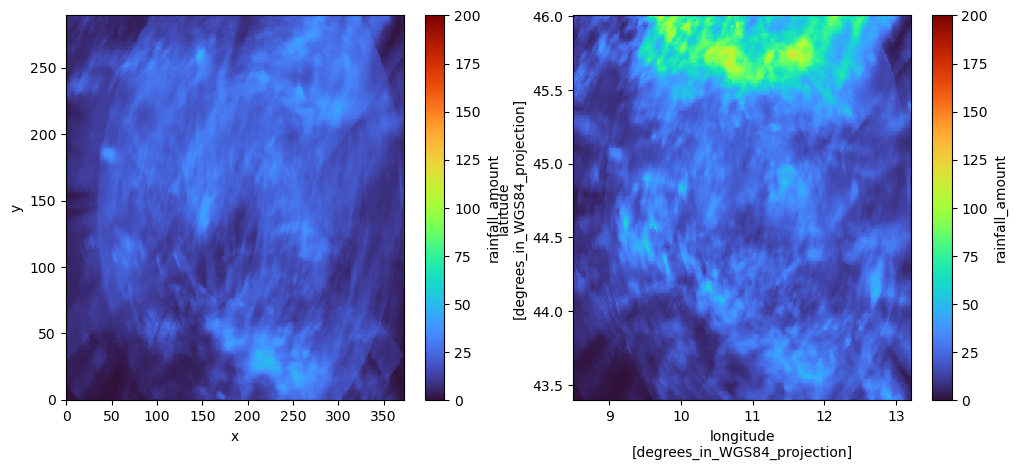

In [199]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ds_radar.rainfall_amount.resample(time='1h').mean().sum(dim='time').plot(ax=axs[0], vmin=0, vmax= 200, cmap='turbo')
ds_radar_adjusted.rainfall_amount.resample(time='1h').mean().sum(dim='time').plot(ax=axs[1], vmin=0, vmax=200, cmap='turbo')

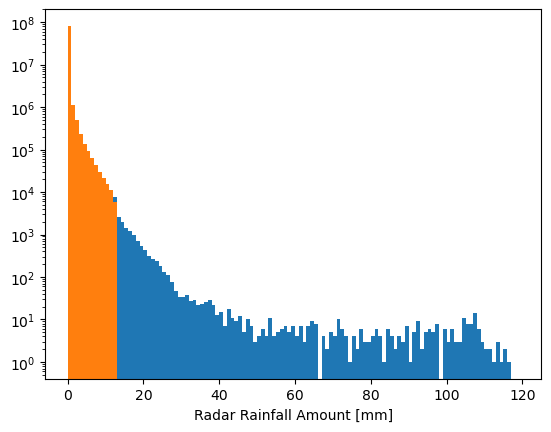

In [221]:
bins=np.arange(0, 120, 1)
ds_radar.R_gauge_adjusted.plot.hist(bins=bins, yscale='log');
ds_radar.R.plot.hist(bins=bins, yscale='log');


In [231]:
ds_radar.R.max().data

array(12.15615654)

In [232]:
ds_radar.R_gauge_adjusted.max().data

array(116.49761963)

In [233]:
ds_radar.R.attrs

{'long_name': 'Radar Rainfall Amount',
 'units': 'mm',
 'standard_name': 'rainfall_amount',
 'valid_min': np.float64(0.0),
 'valid_max': np.float64(10000.0),
 'detection_minimum': np.float64(0.0),
 'undetectable': np.float64(0.0),
 'accum_time_h': np.float64(0.25)}

In [234]:
ds_radar.R_gauge_adjusted.attrs

{'long_name': 'Adjusted Radar Rainfall Amount',
 'units': 'mm',
 'standard_name': 'rainfall_amount',
 'valid_min': np.float64(0.0),
 'valid_max': np.float64(10000.0),
 'detection_minimum': np.float64(0.0),
 'undetectable': np.float64(0.0),
 'accum_time_h': np.float64(0.25)}

## CML processing

In [236]:
ds_cmls["tl"] = ds_cmls.tsl - ds_cmls.rsl

ds_cmls['tl'] = ds_cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

# flag cmls with strong diurnal fluctuation
qc_diurnalcicle = (ds_cmls.tl.rolling(time=60 * 6, center=True).std() > 2).mean(dim="time") > 0.2

# flag cmls with very noisy periods
qc_noisyperiods = (ds_cmls.tl.rolling(time=60, center=True).std() > 0.8).mean(dim="time") > 0.20

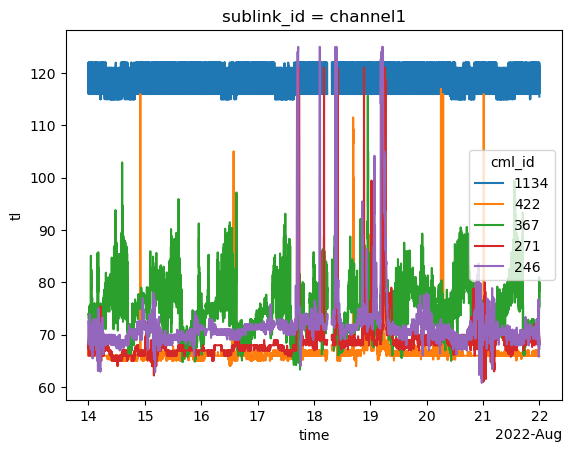

In [237]:
ds_cmls.where(qc_diurnalcicle, drop=True).isel(sublink_id=0).tl.plot.line(x='time');

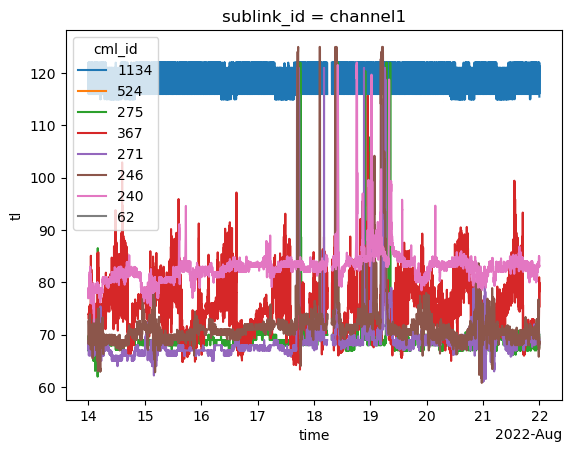

In [238]:
ds_cmls.where(qc_noisyperiods, drop=True).isel(sublink_id=0).tl.plot.line(x='time');

In [239]:
ds_cmls

<xarray.Dataset> Size: 234MB
Dimensions:       (time: 11412, sublink_id: 2, cml_id: 151)
Coordinates:
  * time          (time) datetime64[ns] 91kB 2022-08-14 ... 2022-08-21T23:59:00
  * sublink_id    (sublink_id) <U8 64B 'channel1' 'channel2'
  * cml_id        (cml_id) <U4 2kB '412' '154' '1149' '55' ... '60' '434' '62'
    length        (cml_id) float64 1kB 6.115e+03 2.107e+03 ... 1.037e+03
    site_0_lat    (cml_id) float64 1kB 44.16 44.1 44.71 ... 44.79 44.88 44.82
    site_0_lon    (cml_id) float64 1kB 11.01 11.98 9.623 ... 9.755 11.97 9.738
    site_0_elev   (cml_id) float64 1kB 787.7 124.2 1.105e+03 ... -1.0 441.8
    site_1_lat    (cml_id) float64 1kB 44.17 44.11 44.65 ... 44.79 44.84 44.83
    site_1_lon    (cml_id) float64 1kB 11.09 12.0 9.45 ... 9.854 11.95 9.731
    site_1_elev   (cml_id) float64 1kB 671.6 366.5 1.076e+03 ... -0.9 355.8
    frequency     (cml_id, sublink_id) float64 2kB 2.456e+04 ... 2.458e+04
    polarization  (cml_id, sublink_id) object 2kB 'vertical' ... 'vertical'
Data variables:
    rsl           (cml_id, sublink_id, time) float64 28MB -36.88 -36.0 ... -48.0
    tsl           (cml_id, sublink_id, time) float64 28MB 17.0 17.0 ... 18.0
    tl            (cml_id, sublink_id, time) float64 28MB 53.88 53.0 ... 66.0
    wet           (time, cml_id) float64 14MB nan nan nan nan ... nan nan nan
    baseline      (cml_id, sublink_id, time) float64 28MB 53.88 53.0 ... 66.0
    A_obs         (cml_id, sublink_id, time) float64 28MB 0.0 0.0 ... 0.001084
    waa           (cml_id, sublink_id, time) float64 28MB 0.0 0.0 ... 0.001068
    A             (cml_id, sublink_id, time) float64 28MB 0.0 0.0 ... 1.614e-05
    R             (cml_id, sublink_id, time) float64 28MB 0.0 0.0 ... 0.0 0.0
Attributes:
    title:              OpenRainER-CML: Lepida ScpA CML received and transmit...
    file_authors:       Elia Covi (ARPAE-SIMC Bologna (IT)); Giacomo Roversi ...
    institution:        Hydro-Meteorological and Climate Service of Emilia-Ro...
    date:               2025-01-01
    source:             Lepida ScpA, Bologna (IT) https://www.lepida.net/ - C...
    naming_convention:  OpenSense-CML
    license:            https://creativecommons.org/licenses/by/4.0/
    contact:            elia.c.covi@gmail.com
    reference:          https://zenodo.org/doi/10.5281/zenodo.10593848
    version:            1.1

In [240]:
ds_radar

<xarray.Dataset> Size: 998MB
Dimensions:           (time: 768, y: 290, x: 373)
Coordinates:
  * time              (time) datetime64[ns] 6kB 2022-08-14 ... 2022-08-21T23:...
    lon               (y, x) float32 433kB 8.5 8.513 8.525 ... 13.18 13.19 13.21
    lat               (y, x) float32 433kB 43.4 43.4 43.4 ... 46.0 46.0 46.0
Dimensions without coordinates: y, x
Data variables:
    rainfall_amount   (time, y, x) float32 332MB nan nan nan nan ... 0.0 0.0 nan
    R_gauge_adjusted  (time, y, x) float32 332MB nan nan nan nan ... 0.0 0.0 nan
    R                 (time, y, x) float32 332MB nan nan nan nan ... 0.0 0.0 nan
Attributes:
    title:         OpenRainER-RP: radar 15-min accumulated precipitation
    file_authors:  Elia Covi (ARPAE-SIMC Bologna (IT)); Giacomo Roversi (Ca' ...
    institution:   Hydro-Meteorological and Climate Service of Emilia-Romagna...
    date:          2025-01-01
    source:        ARPAE-SIMC, Bologna (IT) - Radar rain depth maps
    license:       https://creativecommons.org/licenses/by/4.0/
    contact:       elia.c.covi@gmail.com
    reference:     https://zenodo.org/doi/10.5281/zenodo.10593848
    version:       1.1

In [241]:
# get radar along CMLs
grid_at_lines = plg.spatial.GridAtLines(
    da_gridded_data=ds_radar.R,
    ds_line_data=ds_cmls,
)

da_radar_along_cmls = grid_at_lines(ds_radar.R)
da_radar_along_cmls


# calculate wet periods
#ds_cmls['roll_std_threshold'] = 1.1 * ds_cmls['tl'].rolling(time=60, center=True).std().quantile(0.85, dim='time')
#ds_cmls['wet'] = ds_cmls.tl.rolling(time=60, center=True).std() > ds_cmls.roll_std_threshold
#ds_cmls['wet'] =    ds_cmls.tl.rolling(time=60).std() > 0.4
ds_cmls['wet'] = (da_radar_along_cmls > 0.1).rolling(time=3, center=True).max()

# calculate baseline
ds_cmls["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cmls.tl,
    wet=ds_cmls.wet,
    n_average_last_dry=5,
)    

# calculate wet antenna effect
ds_cmls["A_obs"] = ds_cmls.tl - ds_cmls.baseline
ds_cmls["A_obs"] = ds_cmls.A_obs.where(ds_cmls.A_obs >= 0, 0)
ds_cmls["waa"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=ds_cmls.A_obs,
    f_Hz=ds_cmls.frequency * 1e6,
    pol=ds_cmls.polarization.data,
    L_km=ds_cmls.length / 1000,
    A_max=6,
    zeta=0.7,  
    d=0.15, 
)

# calculate attenuation caused by rain and remove negative attenuation
ds_cmls["A"] = ds_cmls.tl - ds_cmls.baseline - ds_cmls.waa
ds_cmls["A"].data[ds_cmls.A < 0] = 0
# derive rain rate via the k-R relation
ds_cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cmls.A,
    L_km=ds_cmls.length.astype(float) / 1000,  
    f_GHz=ds_cmls.frequency / 1000,  
    pol=ds_cmls.polarization,
)
ds_cmls["R"].data[ds_cmls.R < 0.01] = 0

## Quick analysis of processed CML data

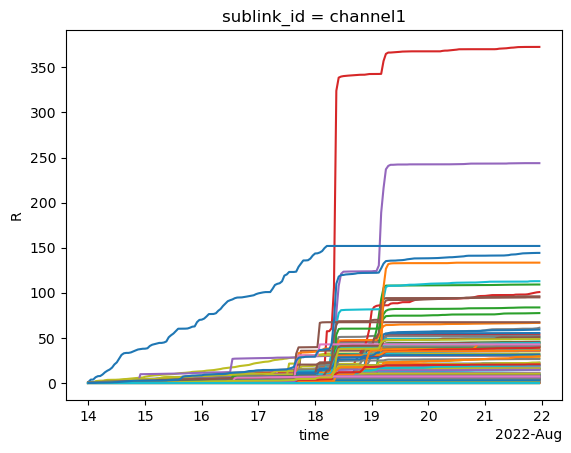

In [242]:
ds_cmls.isel(sublink_id=0).R.resample(time='1h').mean().cumsum(dim='time').plot.line(x='time', add_legend=False);

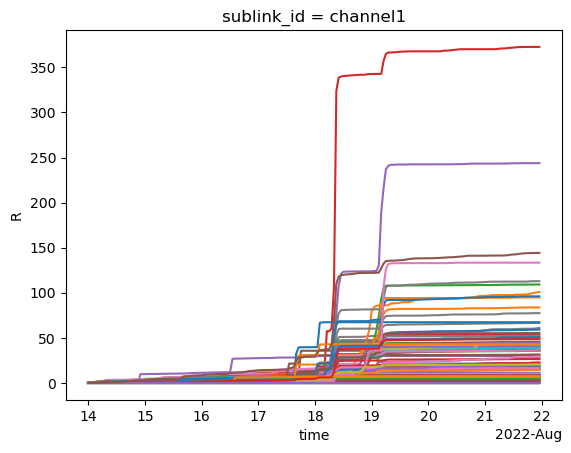

In [243]:
(
    ds_cmls
    .where(~qc_noisyperiods, drop=True)
    .isel(sublink_id=0)
    .R
    .resample(time='1h').mean()
    .cumsum(dim='time')
    .plot.line(x='time', add_legend=False)
);

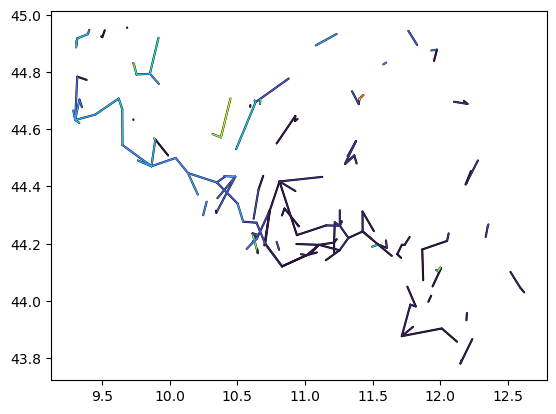

In [244]:
plg.plot_map.plot_lines(ds_cmls.isel(sublink_id=0).R.resample(time='1h').mean().sum(dim='time'), vmin=0, vmax=200)

<Axes: xlabel='lon', ylabel='lat'>

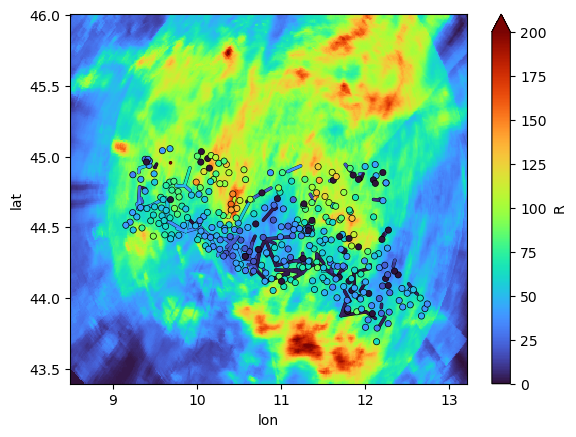

In [245]:
plg.plot_map.plot_plg(
    da_cmls=ds_cmls.isel(sublink_id=0).R.resample(time='1h').mean().sum(dim='time'),
    da_grid=ds_radar.R.resample(time='1h').sum().sum(dim='time'),
    da_gauges=ds_gauges.rainfall_amount.sum(dim='time'),
    vmin=0,
    vmax=200,
)

<Axes: xlabel='lon', ylabel='lat'>

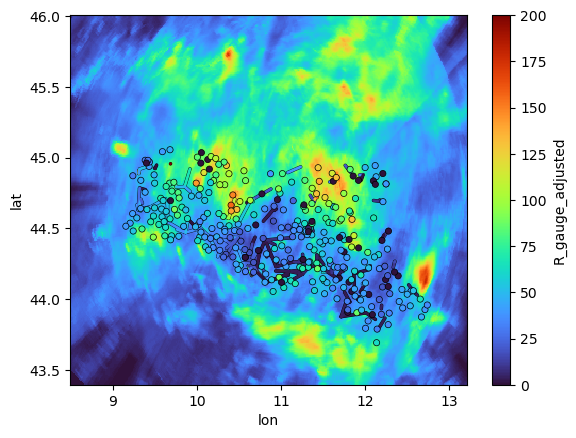

In [246]:
plg.plot_map.plot_plg(
    da_cmls=ds_cmls.isel(sublink_id=0).R.resample(time='1h').mean().sum(dim='time'),
    da_grid=ds_radar.R_gauge_adjusted.resample(time='1h').sum().sum(dim='time'),
    da_gauges=ds_gauges.rainfall_amount.sum(dim='time'),
    vmin=0,
    vmax=200,
)

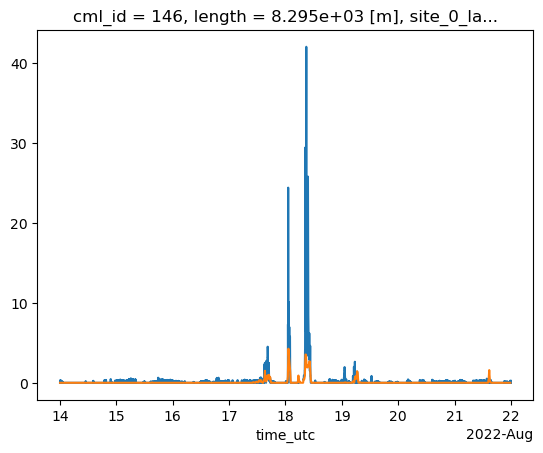

In [247]:
i = 15

ds_cmls.isel(sublink_id=0).isel(cml_id=i).R.plot()
da_radar_along_cmls.isel(cml_id=i).plot()

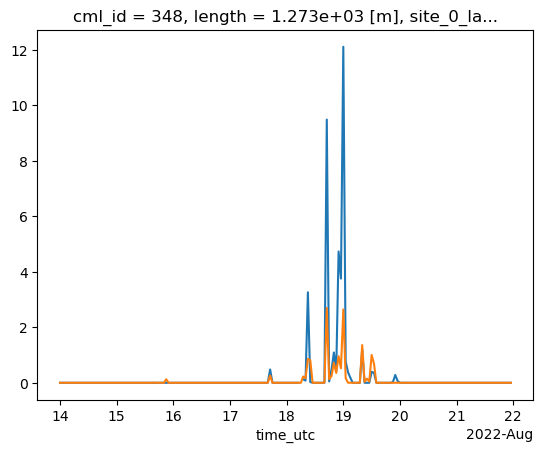

In [248]:
i = 77

ds_cmls.isel(sublink_id=0).isel(cml_id=i).R.resample(time='1h').mean().plot()
da_radar_along_cmls.isel(cml_id=i).resample(time='1h').mean().plot();

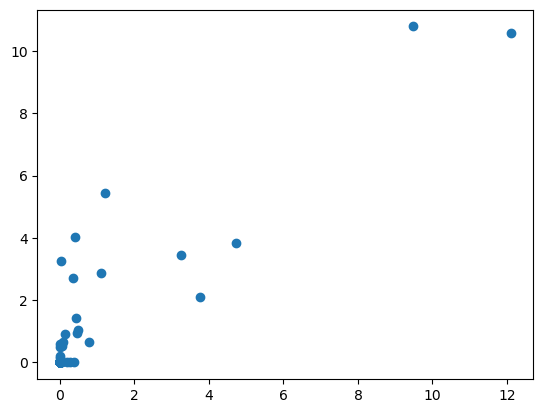

In [249]:
import matplotlib.pyplot as plt
plt.scatter(
    ds_cmls.isel(sublink_id=0).isel(cml_id=i).R.resample(time='1h').mean(),
    da_radar_along_cmls.isel(cml_id=i).resample(time='1h').sum(),
)

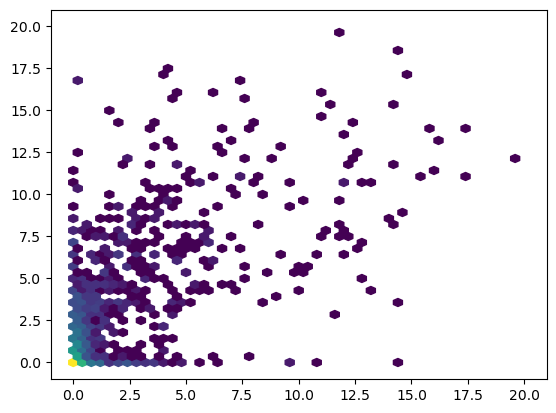

In [250]:
import matplotlib.pyplot as plt
plt.hexbin(
    ds_cmls.isel(sublink_id=0).R.transpose().resample(time='1h').mean().data.flatten(),
    da_radar_along_cmls.resample(time='1h').sum().data.flatten(),
    gridsize=50,
    bins='log',
    extent=[0, 20, 0, 20],
)

Text(0, 0.5, 'Radar along CML rainfall sum over period')

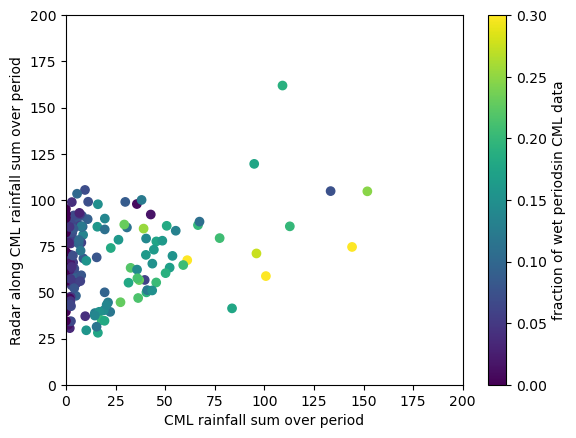

In [251]:
import matplotlib.pyplot as plt
fraction_wet = (ds_cmls.isel(sublink_id=0).R > 0.1).sum(dim='time') / len(ds_cmls.time)

sc = plt.scatter(
    ds_cmls.isel(sublink_id=0).R.transpose().resample(time='1h').mean().sum(dim='time').data,
    da_radar_along_cmls.resample(time='1h').sum().sum(dim='time').data,
    c=fraction_wet,
    vmin=0,
    vmax=0.3,
)
plt.xlim(0, 200)
plt.ylim(0, 200)
plt.colorbar(sc, label='fraction of wet periodsin CML data')
plt.xlabel('CML rainfall sum over period')
plt.ylabel('Radar along CML rainfall sum over period')

## Write CML, gauge and radar data to NetCDF

For now, we do not write the processed CML rain rates since the processing is still not perfect and it is worked on elswhere anyway. Hence we wait for it to be improved.

For the radar we write the unadjusted radar as `R`, as in the OpenMRG dataset, and `R_gauge_adjusted` the gauge-adjusted radar so that both are easily available in one dataset.

In [252]:
ds_gauges.to_netcdf(
    '../openrainer_gauges_8d.nc', 
    encoding={'rainfall_amount': {'zlib': True}},
)

In [253]:
ds_radar.drop_vars('rainfall_amount').to_netcdf(
    '../openrainer_radar_8d.nc', 
    encoding={
        'R':  {'zlib': True, 'dtype': 'int32', 'scale_factor': 0.01, '_FillValue': -9999},
        'R_gauge_adjusted': {'zlib': True, 'dtype': 'int32', 'scale_factor': 0.01, '_FillValue': -9999},
    },
)

In [256]:
ds_cmls.drop_vars(['tl', 'wet', 'baseline', 'A_obs', 'waa', 'A', 'R']).to_netcdf(
    '../openrainer_cml_8d.nc', 
    encoding={
        'tsl': {'zlib': True, 'complevel': 4, 'dtype': 'int16', 'scale_factor': 0.1, '_FillValue': -999},
        'rsl': {'zlib': True, 'complevel': 4, 'dtype': 'int16', 'scale_factor': 0.1, '_FillValue': -999}
    },
)

In [257]:
!ls -ltrh ..

total 34984
drwxr-xr-x@ 8 chwala-c  901   256B Mar 13 22:15 notebooks
-rw-r--r--@ 1 chwala-c  901   124K Mar 14 08:25 openrainer_gauges_8d.nc
-rw-r--r--@ 1 chwala-c  901    15M Mar 14 08:25 openrainer_radar_8d.nc
-rw-r--r--@ 1 chwala-c  901   810K Mar 14 08:25 openrainer_cml_8d.nc
